# Create a User Defined Model using astropy.modeling

## Authors
Rocio Kiman, Lia Corrales and Zé Vinícius.

## Learning Goals
* Learn compound models
* Learn costume models
* Use the model to fit and to compare models (needs discussion)

## Keywords
Modeling, Fit, Costume Models, Compound Models 

## Summary
In this tutorial, we will learn how to define a new model in two ways: with a compound model and with a costume model.

### Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.modeling import models, fitting
from astropy.modeling.models import custom_model

Let's search for spectrum in the [SDSS database](https://dr12.sdss.org/basicSpectra)
Plate: 1349
MJD: 52797
Fiber: 216
And download the fits file. Save it in the same folder the tutorial is.

## Compound models

Let's make a [compound model](http://docs.astropy.org/en/stable/modeling/#compound-models) that is the sum of two existent models in astopy

In [3]:
spectrum = fits.open('spec-1349-52797-0216.fits')

In [4]:
flux = spectrum[1].data['flux']
lam = 10**(spectrum[1].data['loglam'])

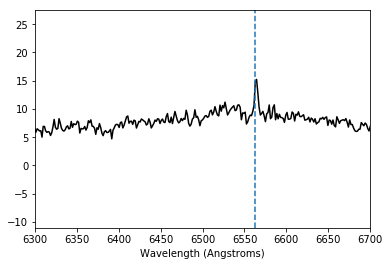

In [5]:
plt.plot(lam, flux, color='k')
plt.xlim(6300,6700)
plt.axvline(x=6563, linestyle='--')
plt.xlabel('Wavelength (Angstroms)')
plt.show()

In [6]:
gg_init = models.Gaussian1D(1, 6563, 10) + models.Polynomial1D(degree=1)   
fitter = fitting.LevMarLSQFitter()
mask = (lam > 6450) * (lam < 6650) 
gg_fit = fitter(gg_init, lam, flux)

Text(0,0.5,'Flux')

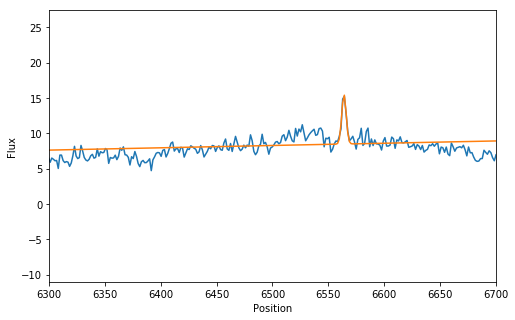

In [7]:
# Plot the data with the best-fit model
plt.figure(figsize=(8,5))
plt.plot(lam, flux)
plt.plot(lam, gg_fit(lam))
plt.xlim(6300,6700)
plt.xlabel('Position')
plt.ylabel('Flux')

In [7]:
print(gg_fit)

Model: CompoundModel0
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Gaussian1D(amplitude=1., mean=6563., stddev=10.)>

    [1]: <Polynomial1D(1, c0=0., c1=0.)>
Parameters:
       amplitude_0           mean_0       ...         c1_1        
    ------------------ ------------------ ... --------------------
    7.0208917442781855 6564.1363171493185 ... 0.003239952053005842


## Costume model

Now let's make a [costume model](http://docs.astropy.org/en/stable/modeling/new.html)

Another spectrum: http://skyserver.sdss.org/dr14/en/tools/explore/Summary.aspx?ra=185.91121611&dec=6.95408363

In [32]:
x = np.linspace(0,10,1000)
y = 2.0*np.exp(x)*(x+5)**(1/3)

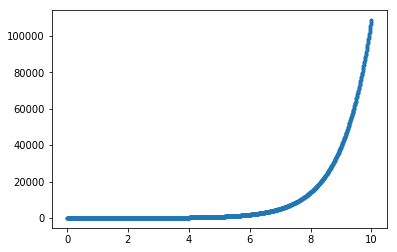

In [33]:
plt.plot(x,y,'.')
plt.show()

In [26]:
@custom_model
def exponential(x, a=1., b=1., c=1.):
    '''
    f(x)=a*exp(b*x + c)
    '''
    return a*np.exp(b*x+c)

In [27]:
exp_model = exponential()  
fitter = fitting.LevMarLSQFitter()
exp_fit = fitter(exp_model, x, y)

In [28]:
print(exp_fit)

Model: exponential
Inputs: ('x',)
Outputs: ('x',)
Model set size: 1
Parameters:
            a                 b                   c         
    ----------------- ------------------ -------------------
    4.804097800684023 1.0555371768002728 -0.2790388252942951


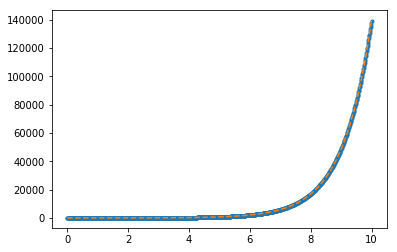

In [29]:
plt.plot(x,y,'.')
plt.plot(x,exp_fit(x),'--')
plt.show()